In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
CAREER_LENGTH = 1

#EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3]
#RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
RECOGNITION_CUT_OFF_LIST = [5]

MAX_CAREER_LEN = 15
END_YEAR = 2018

In [78]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')

In [79]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_qual_3', 'succ_after_15y',
       'early_career_prod_3', 'early_career_coauthor_max_cit_3',
       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC3_RC5',
       'h-index_15', 'h-index_3'],
      dtype='object')

In [80]:
credible_authors = credible_authors[credible_authors.career_length >= CAREER_LENGTH]

In [81]:
credible_authors['citation_increase_15_3'] = credible_authors['succ_after_15y'] - credible_authors[
    'early_career_recognition_EC3_RC3']

In [82]:
credible_authors['h_index_increase_15_3'] = credible_authors['h-index_15'] - credible_authors['h-index_3']

## Data first look

In [94]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_qual_3', 'succ_after_15y',
       'early_career_prod_3', 'early_career_coauthor_max_cit_3',
       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC3_RC5',
       'h-index_15', 'h-index_3', 'citation_increase_15_3',
       'h_index_increase_15_3'],
      dtype='object')

In [8]:
credible_authors.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,early_career_degree_3,early_career_qual_3,early_career_recognition_EC3_RC3,early_career_recognition_EC3_RC5,succ_after_15y,h-index_15,early_career_prod_3,early_career_coauthor_max_cit_3,citation_increase_15_3
0,'maseka lesaoana,2001,2015,2,15,14,5.0,True,none,0.0,23.0,2.0,5.0,23.0,1.0,1,0.0,21.0
1,(max) zong-ming cheng,2009,2011,2,3,13,5.0,True,none,14.0,4.0,3.0,4.0,4.0,1.0,2,8.0,1.0
2,(zhou) bryan bai,2011,2012,2,2,14,5.0,True,none,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
3,a aart blokhuis,1992,2005,2,14,13,5.0,True,none,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0
4,a ahrabian,2017,2017,1,1,15,7.5,True,none,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0


## Correlations

In [ ]:
cor_qual = credible_authors.corr()

In [ ]:
cor_qual
#cor_qual['succ_after_15y'].sort_values()

In [ ]:
#cor_rec = credible_authors[['early_career_recognition_EC1_RC3', 'early_career_recognition_EC1_RC5',
#       'early_career_recognition_EC1_RC7', 'early_career_recognition_EC1_RC9',
#       'early_career_recognition_EC2_RC3', 'early_career_recognition_EC2_RC5',
#       'early_career_recognition_EC2_RC7', 'early_career_recognition_EC2_RC9',
#       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC3_RC5',
#       'early_career_recognition_EC3_RC7', 'early_career_recognition_EC3_RC9',
#       'early_career_recognition_EC4_RC5', 'early_career_recognition_EC4_RC7',
#       'early_career_recognition_EC4_RC9', 'early_career_recognition_EC5_RC5',
#       'early_career_recognition_EC5_RC7', 'early_career_recognition_EC5_RC9',
#       'succ_after_15y']].corr()

In [ ]:
#cor_rec['succ_after_15y'].sort_values()

In [ ]:
cor = credible_authors.corr()

In [ ]:
cor['citation_increase_15_3'].sort_values()

In [ ]:
sns.heatmap(cor, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear reg

In [9]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle

In [10]:
# test different early career lenghts

In [11]:
year = 1995

credible_authors_1991 = credible_authors[credible_authors.start_year == year]

In [12]:
X = credible_authors_1991.copy()


In [13]:
categorical_cols = ['gender']

for col in categorical_cols:
    X = X.join(pd.get_dummies(X[categorical_cols]))

X.drop(categorical_cols, axis=1, inplace=True)

### Test different predictors

In [ ]:
def run_linear(func, name):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            reg = func.fit(H, y)
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': reg.score(H, y)}, ignore_index=True)
    return df

In [ ]:
def run_cv(func, name, cv, y_col='succ_after_15y'):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            y = X[y_col]
            score = np.mean(cross_val_score(func, H, y, cv=cv, scoring='r2'))
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': score}, ignore_index=True)
    return df

In [ ]:
df1 = run_cv(LinearRegression(), 'linear', cv=3)

In [ ]:
# df1_null = run_cv(LinearRegression(), 'linear_null', cv=3, y_col='succ_shuffled')

In [ ]:
df2 = run_cv(ElasticNet(), 'elastic', cv=3)

In [ ]:
df3 = run_cv(ElasticNetCV(cv=3), 'elastic_CV', cv=3)

In [ ]:
df4 = run_cv(Lasso(alpha=0.1), 'lasso', cv=3)

In [ ]:
# Decision tree overfits pretty bad. Maybe GridParam Search?
df5 = run_cv(DecisionTreeRegressor(), 'tree', cv=3)

In [ ]:
df6 = run_cv(RandomForestRegressor(), 'forest', cv=3)

In [ ]:
# df6_null = run_cv(RandomForestRegressor(), 'forest_null', cv=3, y_col='succ_shuffled')

In [ ]:
dfs = [df1, df2, df3, df4, df5, df6] #df1_null, df6_null
for df_ in dfs: df_.set_index('params', inplace=True)

In [ ]:
dfs[0].join(dfs[1:])

### Elastic net

In [45]:
years = sorted(credible_authors.start_year.unique())
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LEN)]
EARLY_CAREER = EARLY_CAREER_LEN_LIST[0]
RECOGNITION_CUT = RECOGNITION_CUT_OFF_LIST[0]


In [46]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score

In [64]:
cols_std = [f'early_career_degree_{EARLY_CAREER}',
       f'early_career_prod_{EARLY_CAREER}', f'early_career_coauthor_max_cit_{EARLY_CAREER}',
       f'early_career_qual_{EARLY_CAREER}', 
#             f'early_career_recognition_EC3_RC3',
#             f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}'
           ] 
cols_all = [f'early_career_degree_{EARLY_CAREER}',
       f'early_career_prod_{EARLY_CAREER}', f'early_career_coauthor_max_cit_{EARLY_CAREER}',
       f'early_career_qual_{EARLY_CAREER}', 
#             f'early_career_recognition_EC3_RC3',
#         f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}',
       'gender_m', 'gender_f',  'intercept', 'r2', 'adj_r2', 'cohort_size'] #'gender_none', 
categorical_cols = ['gender']

In [125]:
feature_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
feature_table2 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
feature_table3 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')

for year in cohort_start_years:
    credible_authors_year = credible_authors[credible_authors.start_year == year]
    #std all
    #credible_authors_year = credible_authors_std[credible_authors_std.start_year == year]
    X = credible_authors_year.copy()
    
    # Make dummy values for categorical columns
    gender_cols = pd.get_dummies(X[categorical_cols])
    # drop gender none?
    gender_cols.drop('gender_none', axis=1, inplace=True)
      
    #standardize cols_std
    # Maybe RobustScaler leads to better results????
    standardized_cols = RobustScaler().fit_transform(X[cols_std])
    #std all
    #standardized_cols = X[cols_std]
    
    #combine
    H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
    H = H.join(gender_cols)

    y = X['h_index_increase_15_3']
    y2 = X['citation_increase_15_3']
    y3 = X['dropped_after_10'].astype(int)


    net = ElasticNetCV(cv=3)
    net.fit(H, y)
    net2 = ElasticNetCV(cv=3)
    net2.fit(H, y2)
#     net3 = ElasticNetCV(cv=3)
    net3 = LogisticRegressionCV(cv=3)
    net3.fit(H, y3)
    score = np.mean(cross_val_score(net, H, y, cv=3, scoring='r2'))
    score2 = np.mean(cross_val_score(net2, H, y2, cv=3, scoring='r2'))
    cohort_size = len(y2)
    num_nonzero_coefs = sum(net2.coef_ != 0)
    adj_score2 = 1 - (1-score2)*(cohort_size-1)/(cohort_size-num_nonzero_coefs-1)
    score3 = np.mean(cross_val_score(net3, H, y3, cv=3, scoring='accuracy'))
    
    net_coef = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                      np.append(net.coef_, [net.intercept_, score, cohort_size]))), 
                             columns=['year', year]).set_index('year')
    net_coef2 = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'adj_r2', 'cohort_size']), 
                                      np.append(net2.coef_, [net2.intercept_, score2, adj_score2, cohort_size]))), 
                             columns=['year', year]).set_index('year')
    net_coef3 = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                      np.append(net3.coef_, [net3.intercept_, score3, cohort_size]))),
                             columns=['year', year]).set_index('year')

    feature_table = feature_table.join(net_coef)
    feature_table2 = feature_table2.join(net_coef2)
    feature_table3 = feature_table3.join(net_coef3)

#### Feature tables

In [126]:
results = feature_table.transpose()
#shorten column names
new_cols = dict(zip(results.columns, [col.replace('early_career', 'ec') for col in results.columns]))

results.rename(new_cols, axis='columns', inplace=True)
results.rename({'ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)

In [127]:
results2 = feature_table2.transpose()
results2.rename(new_cols, axis='columns', inplace=True)
results2.rename({'ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)

In [128]:
results3 = feature_table3.transpose()
results3.rename(new_cols, axis='columns', inplace=True)
results3.rename({'ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)

In [129]:
results3

feature,ec_degree_3,ec_prod_3,ec_coauth_max_cit_3,ec_qual_3,gender_m,gender_f,intercept,r2,adj_r2,cohort_size
1970,0.0752296,-0.78748,-9.45851e-05,-0.138942,-0.31606,-0.311877,[1.7496758863474868],0.770619,NaN,763
1971,0.138295,-1.15434,0.00204204,-0.0514901,-0.208816,-0.0446864,[1.5471181105830158],0.75841,NaN,981
1972,0.302208,-0.67829,-0.0220214,-0.109685,-0.237628,-0.0276104,[1.4338075719366674],0.762221,NaN,1207
1973,0.121317,-0.705225,-0.00871995,-0.107362,-0.104822,0.0424904,[1.3049191120707997],0.744256,NaN,1400
1974,-0.0113207,-0.810605,-0.00404019,-0.0547519,-0.0936687,0.0475974,[1.6747606897108902],0.796721,NaN,1830
1975,0.0576827,-1.01108,0.00276337,-0.0160765,-0.207582,-0.0311499,[1.5069599689738549],0.773606,NaN,1599
1976,-0.0243055,-0.834427,-0.00459469,-0.0127419,-0.277597,0.0189087,[1.5888212555693795],0.763527,NaN,1996
1977,0.0130997,-1.01052,-0.002199,-0.0372838,-0.382112,0.0278034,[1.455579731544274],0.735601,NaN,1929
1978,0.0714681,-0.793546,-0.0140056,0.00453009,-0.289359,0.231414,[1.3469134980256259],0.738333,NaN,1907
1979,0.100116,-1.00919,-0.0187478,-0.0551468,-0.256024,-0.147024,[1.423154190321462],0.73767,NaN,2352


#### predictor diffs

In [92]:
h_index = feature_table.transpose().copy()
citations = feature_table2.transpose().copy()

Average difference in r squared 0.15023032218523338


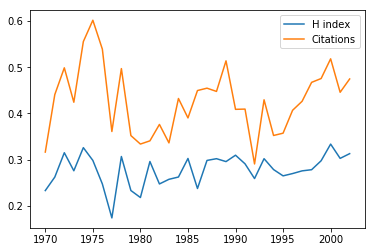

In [93]:
plt.plot(h_index['r2'], label='H index')
plt.plot(citations['r2'], label='Citations')
print("Average difference in r squared", sum(citations['r2']-h_index['r2'])/len(h_index['r2']))
# quality was used as a feature!
plt.legend()
plt.show()

#### gender diffs

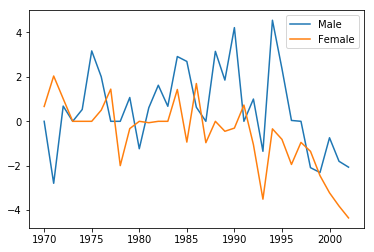

In [21]:
# gender coefs
plt.plot(results['gender_m'], label="Male")
plt.plot(results['gender_f'], label="Female")
plt.legend()
plt.show()

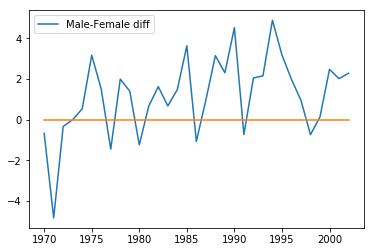

In [22]:
plt.plot(results['gender_m'] - results['gender_f'], label="Male-Female diff")
plt.plot(results.index ,np.zeros(len(results)))
plt.legend()
plt.show()

#### cohort size diffs

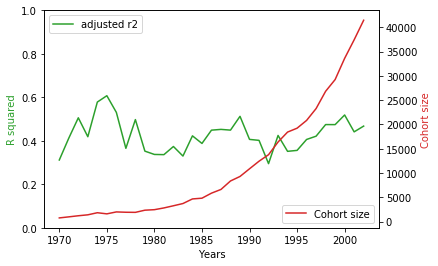

In [30]:
fig, ax1 = plt.subplots()
# ax1.plot(results['r2'], label='r2')
ax1.plot(results['adj_r2'], label='adjusted r2', color='C2')
ax1.set_ylim([0,1])
ax1.set_xlabel('Years')
ax1.set_ylabel('R squared', color='C2')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(results['cohort_size'], label='Cohort size', color='C3')
ax2.set_ylabel('Cohort size', color='C3')
ax2.legend(loc=4)
plt.show()

#### cheating diffs

In [58]:
no_cheating = feature_table2.transpose().copy()

In [63]:
cheat_RC5 = feature_table2.transpose().copy()

In [68]:
cheat_quality = feature_table2.transpose().copy()

Average difference in r squared 0.13851742097370592


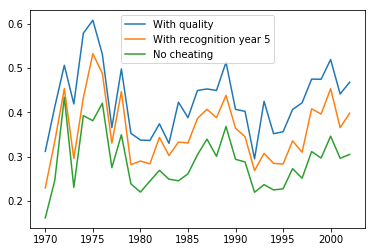

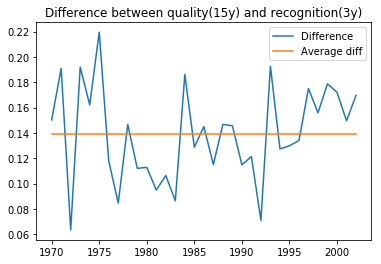

In [74]:
# How does removing the quality affect the r squared?
plt.plot(with_quality['adj_r2'], label='With quality')
plt.plot(cheat_RC5['adj_r2'], label='With recognition year 5')
plt.plot(no_cheating['adj_r2'], label='No cheating')
print("Average difference in r squared", sum(with_quality['adj_r2']-no_cheating['adj_r2'])/len(cheat_quality))
print(np.mean)
plt.legend()
plt.show()

avg = sum(cheat_quality['adj_r2']-no_cheating['adj_r2'])/len(no_cheating)
plt.plot(cheat_quality['adj_r2']-no_cheating['adj_r2'], label='Difference')
plt.plot(no_cheating.index, [avg]*len(no_cheating), label='Average diff')
plt.title("Difference between quality(15y) and recognition(3y)")
plt.legend()
plt.show()

#### scaler diffs

In [31]:
std_scaler = feature_table2.transpose().copy()

In [35]:
rob_scaler = feature_table2.transpose().copy()

Average difference in r squared 0.00047819684153926564


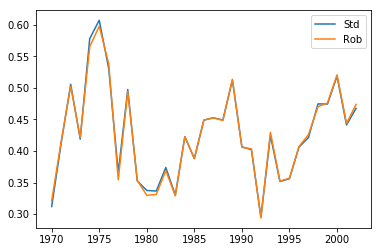

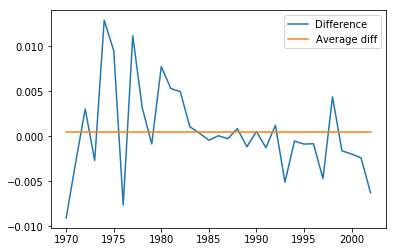

In [40]:
# How does changing the scaler affect the r squared?
plt.plot(std_scaler['adj_r2'], label='Std')
plt.plot(rob_scaler['adj_r2'], label='Rob')
print("Average difference in r squared", sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(rob_scaler))
plt.legend()
plt.show()
# almost no difference

avg = sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(std_scaler)
plt.plot(std_scaler['adj_r2']-rob_scaler['adj_r2'], label='Difference')
plt.plot(std_scaler.index, [avg]*len(std_scaler), label='Average diff')
plt.legend()
plt.show()

In [ ]:
# feature_table3.transpose()

### Best feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from collections import defaultdict

In [ ]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        col_name = "Mutual Information"
    
    feat_selector = feat_selector.fit(data_frame, target)
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores 

def get_features_rfe(data_frame, target, model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

def get_features_rfecv(data_frame, target, model, cv=3):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFECV(model, step=1, cv=cv)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

In [ ]:
years = credible_authors.start_year.unique()
years = sorted(years)

In [ ]:
df = credible_authors.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    df = df.join(pd.get_dummies(df[categorical_cols]))

df.drop(categorical_cols, axis=1, inplace=True)

#### Show k best - F regression or mutual information

In [ ]:
linear = True
# true - fregression
# false - mutual info

In [ ]:
params = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params.append(show_kbest(X_year, y_year, linear, 5))

In [ ]:
params[0]

In [ ]:
selected_f = defaultdict(int)
for param in params:
    selected = param[param.Support == True]['Attribute'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE

In [ ]:
params_rfe = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[[
        #'max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfe.append(get_features_rfe(X_year, y_year, LinearRegression(),k=5))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfe:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE CV

In [ ]:
params_rfecv = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfecv.append(get_features_rfecv(X_year, y_year, LinearRegression(),cv=3))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfecv:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

### Null experiment

In [ ]:
citations_per_year = pd.read_csv('derived-data/paper-citation-count.csv', header=None, names=['pub_id', 'cit_count'])

In [ ]:
publications = pd.read_csv('derived-data/author-publications.csv')

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
# remove authors by career_len, and add start year
publications = publications.merge(credible_authors[['author', 'start_year']], on='author')

In [ ]:
publications = publications[publications.year <= publications.year + MAX_CAREER_LEN]

In [ ]:
# citations_per_year.head()

In [ ]:
publications['pub_id'] = shuffle(publications['pub_id']).reset_index(drop=True)

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
publications = publications.merge(citations_per_year, on='pub_id', how='left')
publications = publications.fillna(0)

In [ ]:
publications.sort_values(by='author').head(20)

In [ ]:
credible_authors[credible_authors.author == "a min tjoa"]['succ_after_15y']

In [ ]:
credible_authors.set_index('author', inplace=True)

In [ ]:
credible_authors['succ_shuffled'] = publications.groupby('author')['cit_count'].sum()

In [ ]:
credible_authors[['succ_shuffled', 'succ_after_15y']].head()

In [ ]:
credible_authors.columns